## Mounting the Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
dir = '/content/gdrive/My Drive/Dataset numpy array(converted)'

## Importing the necessary Libraries

In [3]:
import os
import cv2
import numpy as np
import time

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

## Pre-trained Faster RCNN Model's URL 

In [4]:
faster_rcnn_url = "https://www.kaggle.com/models/google/faster-rcnn-inception-resnet-v2/TensorFlow1/faster-rcnn-openimages-v4-inception-resnet-v2/1"

## Preprocessing Utility Functions

In [5]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [6]:
def load_and_resize_image(image_path, new_width=256, new_height=256, display=False):
    pil_image = Image.open(image_path)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    if display:
        display_image(pil_image_rgb)
    return np.array(pil_image_rgb)

In [7]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color='red', font=None, thickness=4, display_str_list=()):
    
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    left, right, top, bottom = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)

    display_str_heights = [font.getbbox(ds)[3] if font else 10 for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    text_bottom = top if top > total_display_str_height else top + total_display_str_height

    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str) if font else (0, 0, 50, 10)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin

In [8]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        font = ImageFont.load_default()

    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])

    return np.array(image_pil)

## The Raw Image

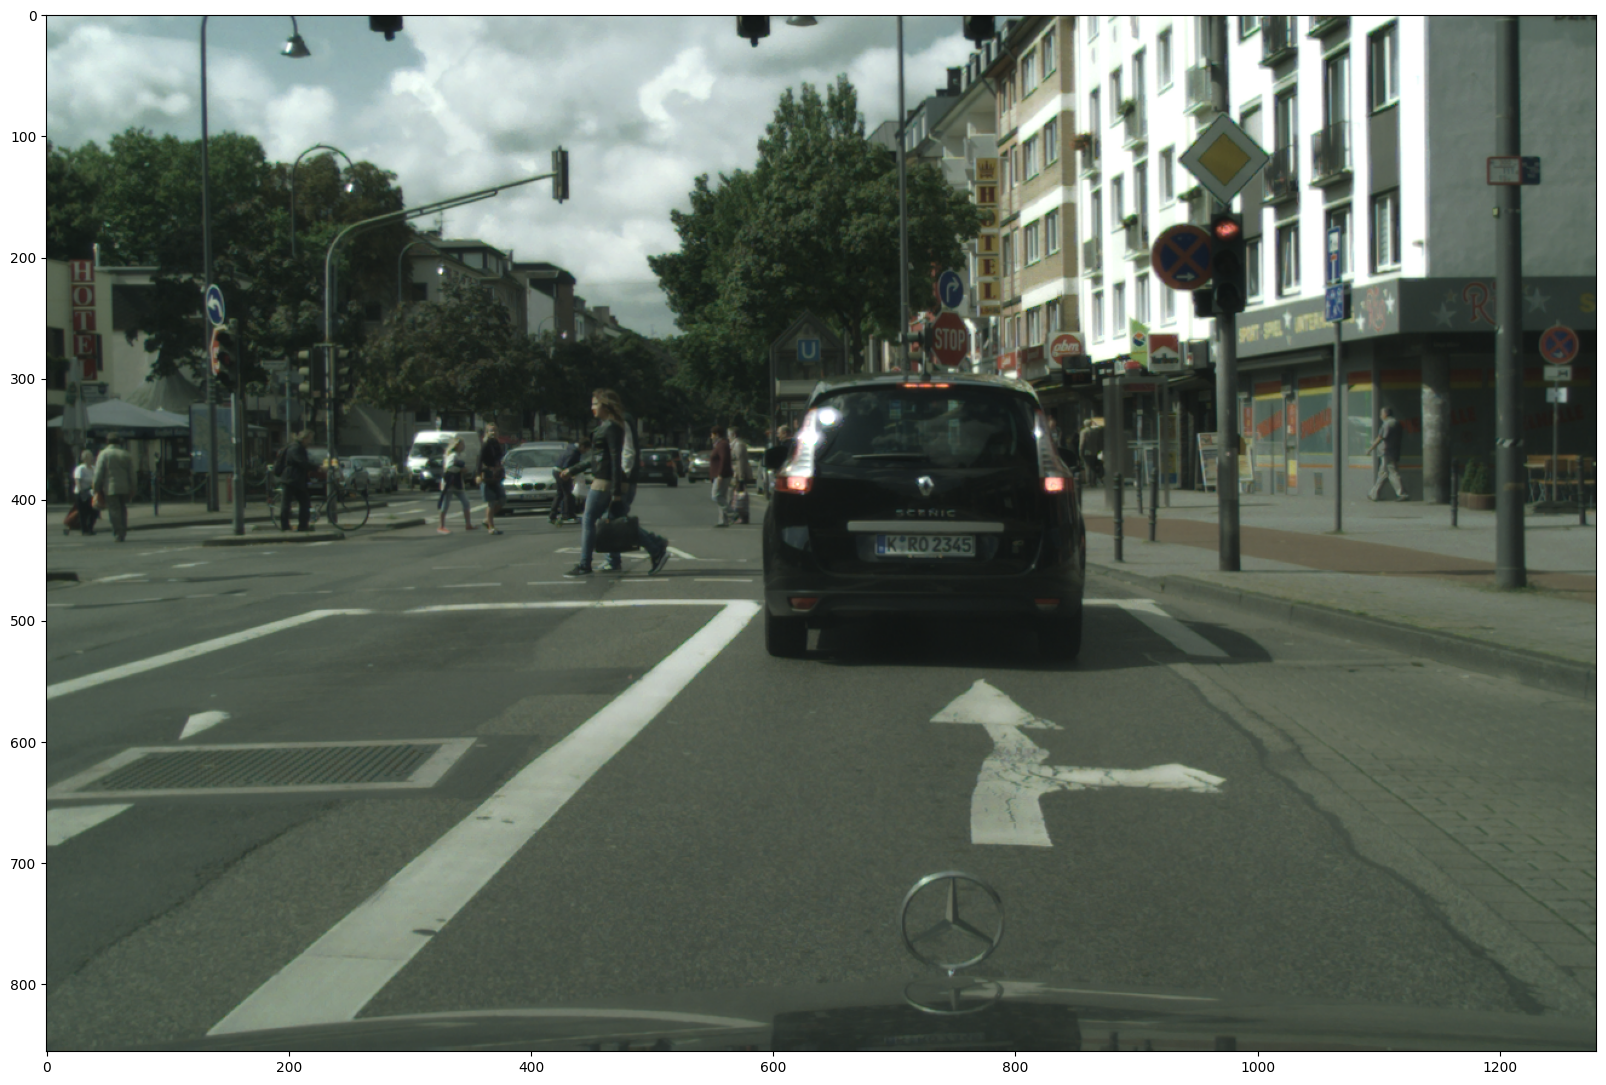

In [9]:
image_path = dir + r"/cologne_000006_000019_leftImg8bit.png"
processed_image = load_and_resize_image(image_path, 1280, 856, display=True)

## Post-processing Utility Functions

In [10]:
detector = hub.load(faster_rcnn_url).signatures['default']

In [11]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [12]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

## Model's Predicted output

Found 100 objects.
Inference time:  1.2622227668762207


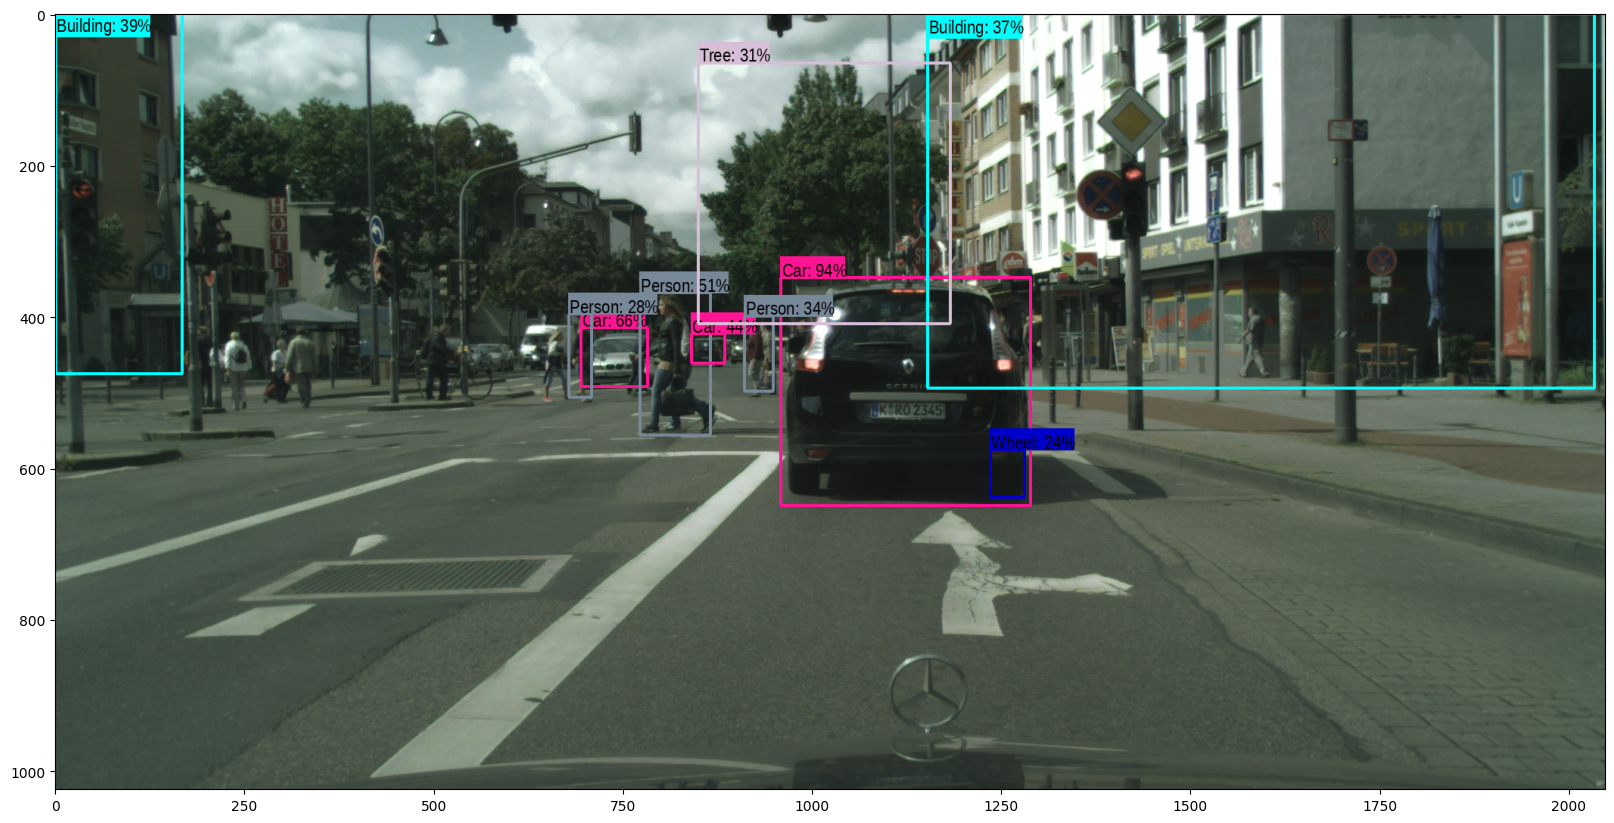

In [17]:
run_detector(detector, dir + '/cologne_000006_000019_leftImg8bit.png')